In [625]:
# import packages
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

sns.set_theme()

In [626]:
# set flag for which metric we are calibrating LR with
METRIC = 'pythagorean point ratio' # possible values are 'point diff', 'point ratio', 'pythagorean point ratio', 'dsr', 'game control', 'dvoa'

([<matplotlib.axis.XTick at 0x15d2f1ae0>,
 [Text(-39, 0, '−39'),
  Text(-36, 0, '−36'),
  Text(-33, 0, '−33'),
  Text(-30, 0, '−30'),
  Text(-27, 0, '−27'),
  Text(-24, 0, '−24'),
  Text(-21, 0, '−21'),
  Text(-18, 0, '−18'),
  Text(-15, 0, '−15'),
  Text(-12, 0, '−12'),
  Text(-9, 0, '−9'),
  Text(-6, 0, '−6'),
  Text(-3, 0, '−3'),
  Text(0, 0, '0'),
  Text(3, 0, '3'),
  Text(6, 0, '6'),
  Text(9, 0, '9'),
  Text(12, 0, '12'),
  Text(15, 0, '15'),
  Text(18, 0, '18'),
  Text(21, 0, '21'),
  Text(24, 0, '24'),
  Text(27, 0, '27'),
  Text(30, 0, '30'),
  Text(33, 0, '33'),
  Text(36, 0, '36'),
  Text(39, 0, '39')])

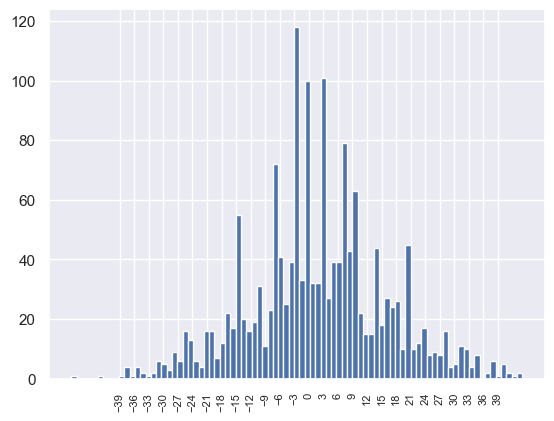

In [627]:
# create dataframe containing home team, away team, point differential (home - away, 0 if OT)
games = nfl.import_schedules([2022, 2021, 2019, 2018, 2017, 2016, 2015])
games.dropna(axis=0)
games['home_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['away_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['result'] = [0 if row['overtime'] else row['result'] for (index, row) in games.iterrows()] # replace overtime scores with 0
nfldata = games[games['season'] != 2022][[
    'away_team', 'home_team', 'away_score', 'home_score', 'total', 'result', 'overtime', 'div_game', 'game_type', 'season', 'gameday'
    ]]

# merge ingame_stats dataframe
ingame_stats = pd.read_csv('data/ingame_stats.csv').drop('Unnamed: 0', axis=1)
games = games.merge(ingame_stats, 'inner', ['game_id', 'home_team', 'away_team'])
# throw out final week games?

plt.hist(nfldata['result'], bins=len(set(nfldata['result'])))
plt.xticks(range(-39, 40, 3), fontsize=8, rotation=90) # how were plots generated in paper?

In [628]:
# extract all home-and-home matchups
# is only using divisional matchups hurting us? divisional rivalries tend to be more of a tossup than other games
# use all games where met in reg season and playoffs and home field switched in playoffs?

hah_games = nfldata.loc[(nfldata['div_game'] == 1) & (nfldata['game_type'] == 'REG')] # get all regular season divisional games

hah_games['series'] = [
    "".join(sorted([row[1]['home_team'], row[1]['away_team'], str(row[1]['season'])]))
    for row in hah_games.iterrows()] # isolate home-and-home pairs

hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1

/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_94733/3831908585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games['series'] = [
/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_94733/3831908585.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1


In [629]:
# store home-and-home game data in the form [home - away in first matchup, 0 or 1 whether differential negative in second matchup]
# home team from first matchup won iff (home - away) is negative in the second matchup
# probability of *outscoring team in points* in next matchup or outscoring based on that metric?

match METRIC:
    case 'point diff':
        outcomes = [row['result'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'point ratio':
        outcomes = [row['home_score'] / row['total'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'pythagorean point ratio':
        outcomes = [row['home_score']**2 / (row['home_score']**2 + row['away_score']**2) 
        for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]

lr_X = np.array(outcomes)
lr_y = np.array([int(row['result'] < 0) for (index, row) in hah_games.reset_index().iloc[1::2, :].iterrows()])

In [630]:
# train logistic regression on home-and-home matchup data (prob. of original home team winning away in next matchup)
clf = LogisticRegression().fit(lr_X.reshape(-1, 1), lr_y.reshape(-1, 1))
print(clf.coef_[0][0], clf.intercept_[0])

0.03648127681540019 -0.3575880377839173


/Users/aryanmittal/.local/share/virtualenvs/nfl-lrmc--q3Bt42M/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [631]:
# derive home field advantage (h = xhat / 2 = 4.9 for point diff metric)
h = min(outcomes)
for i in np.arange(min(outcomes), max(outcomes), 0.001):
    if abs(clf.predict_proba(np.array([i]).reshape(-1, 1))[0][1] - .5) < .001:
        h = i / 2
        break
print(h)

4.846499999938597


In [632]:
# develop Markov Chain
teams = sorted(list(set(hah_games['home_team'].tolist() + hah_games['away_team'].tolist())))
P = np.zeros((len(teams), len(teams))) # 32x32 transition matrix
n_games = np.zeros(len(teams)) # count number of games played by each team (17 except in rare cases, e.g. Bills/Bengals)
games_2022 = games[(games['season'] == 2022) & (games['game_type'] == 'REG')]

for (index, row) in games_2022.iterrows():
    home_i = teams.index(row['home_team'])
    away_i = teams.index(row['away_team'])
    spread = row['result']
    r_x = clf.predict_proba(np.array(spread + h).reshape(-1, 1))[0][1]

    n_games[home_i] += 1
    n_games[away_i] += 1

    P[home_i, away_i] += 1 - r_x
    P[away_i, home_i] += r_x
    P[home_i, home_i] += r_x
    P[away_i, away_i] += 1 - r_x

P /= n_games # divide each row by number of games played to normalize

In [633]:
prior = np.ones(32) / 32
steady_state = np.linalg.matrix_power(P, 1000)
ratings = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'Team': teams,
    'LRMC Rating': ratings / max(ratings)
})
rating_df.sort_values(by=['LRMC Rating'], ascending=False, inplace=True)
rating_df.reset_index() # how to incorporate home field playoff advantage into Markov chain rankings?

,index,Team,LRMC Rating
0,3,BUF,1.000000
1,6,CIN,0.893581
2,28,SF,0.876405
3,8,DAL,0.855728
4,15,KC,0.852092
5,25,PHI,0.849275
6,2,BAL,0.770156
7,19,MIA,0.737927
8,21,NE,0.735992
9,10,DET,0.721304
